In [37]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [74]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.output_layer = nn.Linear(input_size + hidden_size, output_size)
        self.hidden_layer = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1) 
        
    def forward(self, input_tens, hidden_tens):
        combined = torch.cat((input_tens, hidden_tens), 1)
        
        hidden = self.hidden_layer(combined)
        hidden = self.relu(hidden)
        
        out = self.output_layer(combined)
        out = self.softmax(out) 
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [75]:
#Setup Globals
WORD_COUNT = 316
WORD_DICT = {}
ID_TO_WORD = {}

vocab = pd.read_csv("data/dictionary.txt")
for i in range(WORD_COUNT):
    word = vocab["Word"][i]
    word_id = vocab["Id"][i]
    WORD_DICT[word] = word_id
    ID_TO_WORD[word_id] = word

In [117]:
def tokenize_input(sentence):
    token_list = []
    word = ""
    punctuation = [".", "!", "?"]
    for char in sentence:
        if char == " ":
            token_list.append(word)
            word = ""
        elif char in punctuation:
            token_list.append(word)
            word = ""
            word += char
        else:
            word += char
    token_list.append(word)
    return token_list

def load_data():
    train = pd.read_csv("data/train_lang.txt")
    return train


def sentence_to_tensor(sentence):
    tokens = tokenize_input(sentence)
    tensor = torch.zeros(len(tokens), 1, WORD_COUNT)
    for i, word in enumerate(tokens):
        tensor[i][0][WORD_DICT[word]] = 1
    return tensor

def category_to_tensor(word):
    return torch.tensor([WORD_DICT[word]], dtype=torch.long)
    

def get_random_row(df):
    row_count = df.shape[0]
    rand_ind = random.randrange(row_count)
    x = df["Sentence"][rand_ind]
    y1 = df["First"][rand_ind]
    y2 = df["Second"][rand_ind]
    return x, y1, y2
   
def train_sentence(sentence_tensor, y1_tensor, y2_tensor):
    hidden = rnn_model.init_hidden()
    output = ""
    for i in range(sentence_tensor.size()[0]):
        output, hidden = rnn_model(sentence_tensor[i], hidden)
        
    loss = criterion(output, y1_tensor)
    #optimizer.zero_grad()
    #loss.backward(retain_graph=True)
    #optimizer.step()
    
    #not sure if right
    output, hidden = rnn_model(output, hidden)
    loss = criterion(output, y2_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def convert_output(output_tensor):
    key = torch.argmax(output_tensor).item()
    return ID_TO_WORD[key]

def predict_next_n_words(starting_prompt, n):
    prompt_tensor = sentence_to_tensor(starting_prompt)
    hidden_tens = rnn_model.init_hidden()
    answer = []
    final_sentence = starting_prompt
    with torch.no_grad():
        for i in range(prompt_tensor.size()[0]):
            output, hidden_tens = rnn_model(prompt_tensor[i], hidden_tens)
        new_word = convert_output(output)
        answer.append(new_word)
        for i in range(n-1):
            output, hidden_tens = rnn_model(output, hidden_tens)
            new_word = convert_output(output)
            answer.append(new_word)
    for word in answer:
        final_sentence = final_sentence + " " + word
    return final_sentence
    
    

In [138]:
train = load_data()

In [139]:
n_hidden = 256

rnn_model = RNN(WORD_COUNT, n_hidden, WORD_COUNT)

In [140]:
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=learning_rate)

In [141]:
loss_sum = 0
all_losses = []
plot_step, print_step = 200, 5000
#plot_step, print_step = 1, 1
n_iter = 200000
for i in range(n_iter):

    x, y1, y2 = get_random_row(train)
    x_tensor = sentence_to_tensor(x)
    y1_tensor = category_to_tensor(y1)
    y2_tensor = category_to_tensor(y2)
    output, loss = train_sentence(x_tensor, y1_tensor, y2_tensor)
    loss_sum += loss
    
    if(i+1) % plot_step == 0:
        all_losses.append(loss_sum/plot_step)
        loss_sum = 0
        
    if (i+1) % print_step == 0:
        guess = convert_output(output)
        answer = "CORRECT" if guess == y else "WRONG"
        print(f" iteration={i+1} percent_done={(i+1)/n_iter*100}% loss={loss:.4f} Last Sample Result: {x} / Guess was {guess}"
        f" which is {answer}. Correct answer is {y2}")

 iteration=5000 percent_done=2.5% loss=10.2885 Last Sample Result: You are the object of / Guess was other which is WRONG. Correct answer is affection
 iteration=10000 percent_done=5.0% loss=12.2192 Last Sample Result: I love you more and more / Guess was you which is CORRECT. Correct answer is day
 iteration=15000 percent_done=7.5% loss=9.2759 Last Sample Result: I had an amazing time / Guess was me which is WRONG. Correct answer is you
 iteration=20000 percent_done=10.0% loss=10.3835 Last Sample Result: You turn me / Guess was now which is WRONG. Correct answer is out
 iteration=25000 percent_done=12.5% loss=8.4187 Last Sample Result: I’ll always / Guess was now which is WRONG. Correct answer is you
 iteration=30000 percent_done=15.0% loss=12.0617 Last Sample Result: You are / Guess was born which is WRONG. Correct answer is favorite
 iteration=35000 percent_done=17.5% loss=10.7792 Last Sample Result: I never want to see / Guess was chance which is WRONG. Correct answer is again
 ite

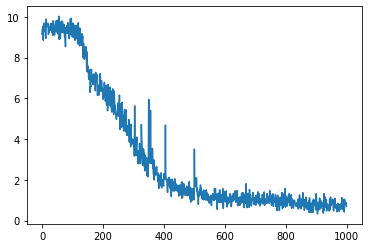

In [142]:
plt.plot(all_losses)
plt.show()

In [155]:
print(predict_next_n_words("How can you", 2))

How can you go on
